In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, dataset, random_split
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import itertools
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import collections
from PIL import ImageFile
import torch.nn.functional as F
from os import listdir
from os.path import isfile, join


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
classes = 'drive/My Drive/MS-ASL/MSASL_classes.json'
train_json = 'drive/My Drive/MS-ASL/MSASL_train.json'
test_json = 'drive/My Drive/MS-ASL/MSASL_test.json'
val_json = 'drive/My Drive/MS-ASL/MSASL_val.json'
train_videos = 'drive/My Drive/HW4_DATA/videos/train/'
val_videos = 'drive/My Drive/HW4_DATA/videos/val/'
test_videos = 'drive/My Drive/HW4_DATA/videos/test/'

In [ ]:
classes = {'hello' : 0, 'nice' :1, 'teacher':2,  'eat':3 , 'no':4, 'happy':5, 'like':6, 'orange':7, 'want' :8, 'deaf':9}

In [ ]:
# video = cv2.VideoCapture('drive/My Drive/HW4_DATA/videos/train/watch?v=7y5Ye-2-ZBs.mp4')
# # totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

# frame = 10
# video.set(cv2.CAP_PROP_POS_FRAMES, frame)

# ret, image = video.read()
# resized = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
# print(ret)
# imgplot = plt.imshow(resized)

In [ ]:
def load_data(path,is_test):
  df = pd.read_json(path)
  for value in df['clean_text'].values:
    if value not in classes.keys():
      df.drop(df[df['clean_text']== value].index, inplace = True)
  df['url'] = df['url'].apply(lambda x : 'w' + x.lstrip('https://www.youtube.com'))
  
  return df

In [ ]:
def clean_data(path, df):
  files = [os.path.splitext(f)[0] for f in listdir(path) if isfile(join(path, f))]
  with_ext = [f for f in listdir(path) if isfile(join(path, f))]
  org_values = df['url'].values
  for value in df['url'].values:
    if value not in files:
      df.drop(df[df['url']== value].index, inplace = True) 
  

  for i in range(0, df.shape[0]):
    if df.iloc[i,12] in files:
      index = files.index(df.iloc[i,12])
      df = df.replace(df.iloc[i,12], with_ext[index])
  return df

In [ ]:
def extract_frames(source, dest, df):
  files = [f for f in listdir(source) if isfile(join(source, f))]
  for i in range(0, df.shape[0]):
    start_frame = df.iloc[i][5]
    end_frame = df.iloc[i][6]
    video = cv2.VideoCapture(source + df.iloc[i][12])
    for j in range(start_frame, end_frame):     
      video.set(cv2.CAP_PROP_POS_FRAMES, j)   
      ret, image = video.read()
      if(ret):
        file_path = dest + df.iloc[i][1] + '/' + df.iloc[i][12] + '_' + str(j) + '.png'
        cv2.imwrite(file_path, image)
      else:
        print(df.iloc[i][12], j)

In [ ]:
train_df = load_data(train_json, False)
train_df = clean_data(train_videos, train_df)
val_df = load_data(val_json, False)
val_df = clean_data(val_videos, val_df)
test_df = load_data(test_json, True)
test_df = clean_data(test_videos, test_df)

In [ ]:
# extract_frames(train_videos, 'drive/My Drive/frames/train/', train_df)
# extract_frames(val_videos, 'drive/My Drive/frames/val/', val_df)
# extract_frames(test_videos, 'drive/My Drive/frames/test/', test_df)

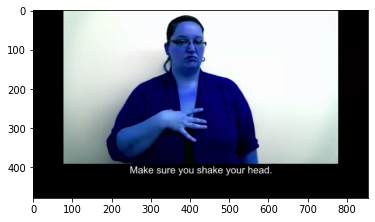

In [ ]:
video = cv2.VideoCapture(train_videos+ train_df.iloc[2][12])
#totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
#print(self.df['end'].values[idx])
frame = int(train_df.iloc[2][6]  -  train_df.iloc[2][5])

video.set(cv2.CAP_PROP_POS_FRAMES, train_df.iloc[2][5])
ret, image = video.read()

plt.imshow(image)

In [ ]:
class SpatialDataset(datasets.ImageFolder):

    def __init__(self,path,df, classes, transform):
      self.path = path
      self.df = df
      self.transform = transform
      self.classes = classes

    def __len__(self):
      return len(self.df)

    def __getitem__(self, idx):

    
      url = self.df.iloc[idx][12]
      
      video = cv2.VideoCapture(self.path + url)
     
      frame = self.df.iloc[idx][6]  - self.df.iloc[idx][5]
      video.set(cv2.CAP_PROP_POS_FRAMES, self.df.iloc[idx][5])
      
      ret, image = video.read()

      if self.transform:
        image = self.transform(image)

      label = self.classes[self.df.iloc[idx][1]]
      # print(frame, label)
      return  (image, label)

In [ ]:
transform = transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),                            
])

In [ ]:
def getdataloader_sizes(batchsize): 
  train =  SpatialDataset( path = train_videos, df = train_df, classes = classes, transform = transform)
  validation = SpatialDataset( path = val_videos, df = val_df,  classes = classes, transform = transform)
  test = SpatialDataset( path = test_videos, df = test_df,  classes = classes, transform = transform)

  
  all_datasets = {'train' : train, 'validation' : validation, 'test' : test}

  dataloaders = {x: torch.utils.data.DataLoader(all_datasets[x], batch_size=batchsize,
                                               shuffle=True)
                for x in ['train', 'validation' ,'test']}
  dataset_sizes = {x: len(all_datasets[x]) for x in ['train', 'validation','test']}

  class_names = list(classes.keys())
  print(class_names)
  print(dataset_sizes)
  return dataloaders,dataset_sizes,class_names

In [ ]:
def plot_confusion_matrix(cm, classes,
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),horizontalalignment="center",color="white" if cm[i, j] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [ ]:
def plot_graph(plotlist1,plotlist2,ylabel):
   
    plt.xlabel("Training Epochs")
    plt.ylabel(ylabel)
    plt.plot(plotlist1, color="green")
    plt.plot(plotlist2, color="yellow")
    
    plt.gca().legend(('Train', 'Validation'))
    plt.show()

In [ ]:
def train_model(model, criterion, optimizer, epoch_number,device,earlystopping):
   
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_train_acc = 0.0
    best_val_acc = 0.0
    best_test_acc = 0.0
    train_acc_history = list()
    train_loss_history =list()
    val_acc_history = list()
    val_loss_history =list()
    
    counter = 0
    stop =False
    best_loss = None
    
   
    n_epochs_stop = 1
    min_val_loss = np.Inf
    epochs_no_improve = 0
    
    for epoch in range(epoch_number):
        if stop:
          break
        print('Epoch {}/{}'.format(epoch, epoch_number - 1))
        
        # Train and validation for each epoch
        for part in ['train', 'validation']:
            if part == 'train':
                
                model.train()  
            else:
                model.eval()  

            current_loss = 0.0
            current_phase_correct_outputnumber = 0
            # For each phase in datasets are iterated
            for inputs, labels in dataloaders[part]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                with torch.set_grad_enabled(part == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # Backpropagate and opitimize Training part
                    if part == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                current_loss += loss.item() * inputs.size(0)
                current_phase_correct_outputnumber += torch.sum(preds == labels.data)

            current_loss = current_loss / dataset_sizes[part]
            epoch_acc = 100*current_phase_correct_outputnumber.double() / dataset_sizes[part]

            if part == 'validation':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(current_loss)
                if earlystopping:
                  # If the validation loss is at a minimum
                  if current_loss < min_val_loss:
                    # Save the model
                    epochs_no_improve = 0
                    min_val_loss = current_loss

                  else:
                    epochs_no_improve += 1
                    # Check early stopping condition
                    if epochs_no_improve == n_epochs_stop:
                      print('Early stopping!')
                      
                      #Printed best accuracies
                      print('Best train Acc: {:4f}'.format(best_train_acc))
                      print('Best validation Acc: {:4f}'.format(best_val_acc))

                      print()

                      #Printed best accuracies
                      print('Best train Acc: {:4f}'.format(best_train_acc))
                      print('Best validation Acc: {:4f}'.format(best_val_acc))

                      # load best model weights
                      model.load_state_dict(best_model_wts)
                      #Plot accuracy graph 
                      plot_graph(train_acc_history,val_acc_history,"Accuracy")
                      plot_graph(train_loss_history,val_loss_history,"Loss")
                      
                      return model                  
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(current_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                part, current_loss, epoch_acc))

            # deep copy the model
            if part == 'train' and epoch_acc > best_train_acc:
                  best_train_acc = epoch_acc
                
            if part == 'validation' and epoch_acc > best_val_acc:             
                best_val_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
              
        print() 
    
              
    print('Best train Acc: {:4f}'.format(best_train_acc))
    print('Best validation Acc: {:4f}'.format(best_val_acc))
    
  
    model.load_state_dict(best_model_wts)
   
    plot_graph(train_acc_history,val_acc_history,"Accuracy")
    plot_graph(train_loss_history,val_loss_history,"Loss")
  
    return model

In [ ]:
class SpatialSimpleNet(nn.Module):
  def __init__(self):
    super(SpatialSimpleNet, self).__init__()
    self.conv1 = torch.nn.Conv2d(3, 18, kernel_size = 3, stride = 1, padding = 1)
    self.pool = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
    self.fc1 = torch.nn.Linear(18 * 112 * 112, 64)
    self.fc2 = torch.nn.Linear(64, 10)


  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)
    x = x.view(-1, 18 * 112 *112)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return(x)

class SpatialNet(nn.Module):
  def __init__(self):
      super(SpatialNet, self).__init__()
      
      self.conv1 = nn.Conv2d(3, 96, 7, stride=2)
      self.relu1 = nn.ReLU()
      self.pool1 = nn.MaxPool2d(3, stride=2)
      self.norm1 = nn.LocalResponseNorm(2)
      self.conv2 = nn.Conv2d(96, 256, 5, stride=2)
      self.relu2 = nn.ReLU()
      self.pool2 = nn.MaxPool2d(3, stride=2)
      self.norm2 = nn.LocalResponseNorm(2)
      self.conv3 = nn.Conv2d(256, 512, 3)
      self.relu3 = nn.ReLU()
      self.conv4 = nn.Conv2d(512, 512, 3)
      self.relu4= nn.ReLU()
      self.conv5 = nn.Conv2d(512, 512, 3)       
      self.relu5 = nn.ReLU()
      self.pool3 =nn.MaxPool2d(3, 2)
  
  
      self.l1 = nn.Linear(2048, 4096)
      self.drop1 = nn.Dropout()
      self.l2 = nn.Linear(4096, 2048)
      self.drop2 = nn.Dropout()
      self.l3 =nn.Linear(2048, 10)
        
      
      

  def forward(self, x):
      x = self.conv1(x)
      x = self.relu1(x)
      x = self.pool1(x)
      x = self.norm1(x)

      x = self.conv2(x)
      x = self.relu2(x)
      x = self.pool2(x)
      x = self.norm2(x)

      x = self.conv3(x)
      x = self.relu3(x)

      x = self.conv4(x)
      x = self.relu4(x)


      x = self.conv5(x)
      x = self.relu5(x)
      x = self.pool3(x)

      x = x.view(x.size(0), -1)

      x = self.l1(x)
      x = self.drop1(x)
      x = self.l2(x)
      x = self.drop2(x)
      x = self.l3(x)

      return x


net = SpatialNet()

['hello', 'nice', 'teacher', 'eat', 'no', 'happy', 'like', 'orange', 'want', 'deaf']
{'train': 378, 'validation': 103, 'test': 92}
Epoch 0/7
train Loss: 2.3032 Acc: 10.8466
validation Loss: 2.3007 Acc: 11.6505

Epoch 1/7
train Loss: 2.3023 Acc: 11.6402
validation Loss: 2.3007 Acc: 8.7379

Epoch 2/7
train Loss: 2.3023 Acc: 9.5238
validation Loss: 2.3008 Acc: 10.6796

Epoch 3/7
train Loss: 2.3008 Acc: 11.9048
validation Loss: 2.3010 Acc: 10.6796

Epoch 4/7
train Loss: 2.3005 Acc: 10.8466
validation Loss: 2.3011 Acc: 10.6796

Epoch 5/7
train Loss: 2.3007 Acc: 11.6402
validation Loss: 2.3012 Acc: 10.6796

Epoch 6/7
train Loss: 2.3005 Acc: 9.7884
validation Loss: 2.3013 Acc: 10.6796

Epoch 7/7
train Loss: 2.2999 Acc: 11.3757
validation Loss: 2.3015 Acc: 10.6796

Best train Acc: 11.904762
Best validation Acc: 11.650485


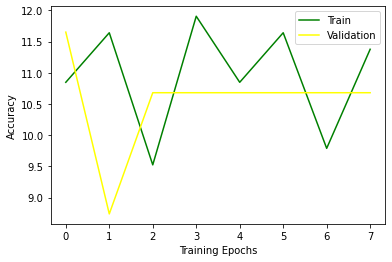

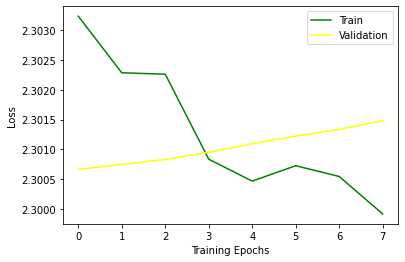

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True 

trainingmodel = net


#initializing parameters
learning_rate = 0.01
epoch = 8
batchsize = 128
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(trainingmodel.parameters(), lr=learning_rate)
earlystoping = False


dataloaders,dataset_sizes,class_names = getdataloader_sizes(batchsize)


trained_model = train_model(trainingmodel, criterion, optimizer,epoch,device,earlystoping)

In [ ]:
def calculateTestAcc(trained_model,dataloaders,dataset_sizes):
  confusion_matrixx = torch.zeros(10, 10)
  np.set_printoptions(precision=2)
  current_phase_correct_outputnumber = 0

  with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device   )
        classes = classes.to(device)
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)
        current_phase_correct_outputnumber += torch.sum(preds == classes.data)
          
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrixx[t.long(), p.long()] += 1
   
    test_acc = 100*current_phase_correct_outputnumber.double() / dataset_sizes['test']

    print('Test Acc: {:4f}'.format(test_acc))
    
  plt.figure(figsize = (10,10))
  plot_confusion_matrix(confusion_matrixx,classes=class_names)
  plt.show()

Test Acc: 8.695652


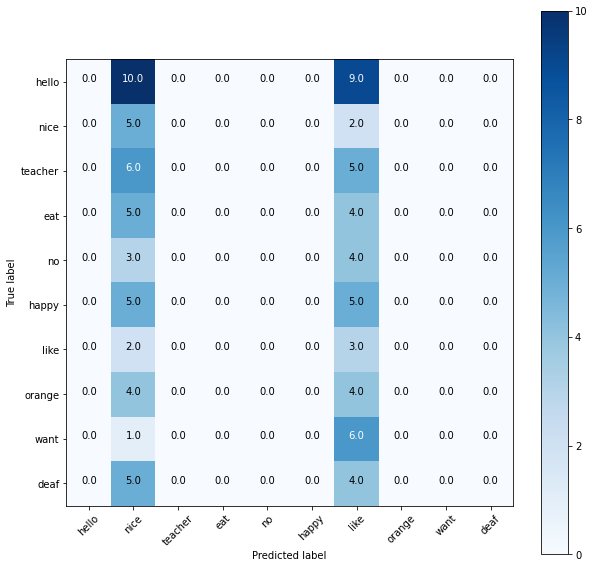

In [ ]:
calculateTestAcc(trained_model,dataloaders,dataset_sizes)